Conexión exitosa


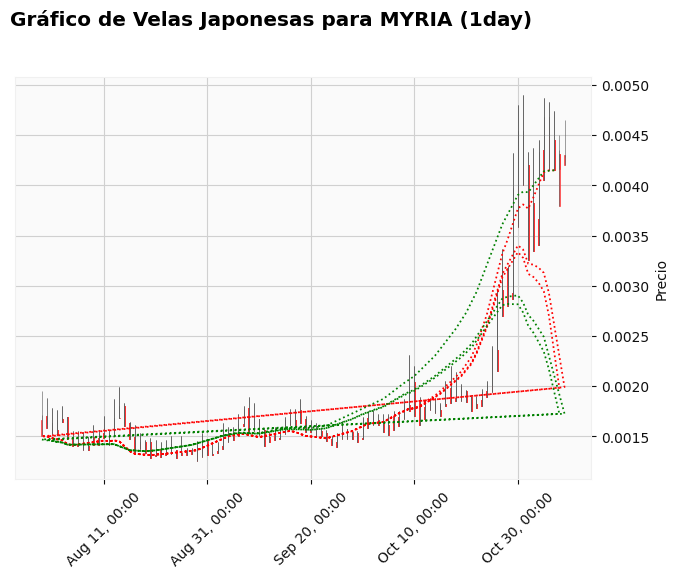

In [8]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf

# Configuración de la base de datos
dbname = "kucoin"
user = "postgres"
password = "6962277"
host = "localhost"
port = "5432"

def establecer_conexion():
    try:
        conn = psycopg2.connect(dbname=dbname, user=user, password=password, host=host, port=port)
        cursor = conn.cursor()
        print("Conexión exitosa")
        return conn, cursor
    except Exception as e:
        print(f"Error de conexión: {e}")
        return None, None

def obtener_datos_moneda(moneda, intervalo):
    conn, cursor = establecer_conexion()
    if conn is not None and cursor is not None:
        cursor.execute(f"SELECT timestamp, open::numeric, high::numeric, low::numeric, close::numeric, volume::numeric FROM historical_data_{intervalo} WHERE currency = %s", (moneda,))
        data = cursor.fetchall()
        conn.close()
        return data
    else:
        return []

def calcular_emas(df):
    df['EMA10'] = df['Close'].ewm(span=10, adjust=False).mean()
    df['EMA20'] = df['Close'].ewm(span=20, adjust=False).mean()
    df['EMA50'] = df['Close'].ewm(span=50, adjust=False).mean()

def generar_grafico_velas(data):
    df = pd.DataFrame(data, columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
    df['Date'] = pd.to_datetime(df['Date'])

    # Ajustar el índice a la columna 'Date' como un DatetimeIndex
    df.set_index('Date', inplace=True)

    # Reducir la precisión de los números de coma flotante
    float_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    df[float_columns] = df[float_columns].astype('float32')

    # Calcular las EMAs
    calcular_emas(df)

    # Crear el gráfico de velas japonesas con etiquetas y volumen
    mpf.plot(df, type='candle', title=f'Gráfico de Velas Japonesas para {moneda} ({intervalo})', ylabel='Precio',
             show_nontrading=True, style='yahoo', addplot=[mpf.make_addplot(df['EMA10'], secondary_y=False, color='r', linestyle='dotted'),
                                                         mpf.make_addplot(df['EMA20'], secondary_y=False, color='g', linestyle='dotted')
                                                         #mpf.make_addplot(df['EMA50'], secondary_y=False, color='b', linestyle='dotted'),
                                                         #mpf.make_addplot(df['Volume'], panel=1, secondary_y=True, color='b', title='Volume')
                                                         ])

if __name__ == "__main__":
    # Establece la moneda y el intervalo por defecto
    moneda = "MYRIA"
    intervalo = "1day"

    data = obtener_datos_moneda(moneda, intervalo)

    if data:
        generar_grafico_velas(data)
        plt.show()
    else:
        print(f"No se encontraron datos para la moneda '{moneda}' en el intervalo '{intervalo}'.")


In [2]:
import mplfinance as mpf

available_styles = mpf.available_styles()
print(available_styles)


['binance', 'binancedark', 'blueskies', 'brasil', 'charles', 'checkers', 'classic', 'default', 'ibd', 'kenan', 'mike', 'nightclouds', 'sas', 'starsandstripes', 'tradingview', 'yahoo']


In [9]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
from decimal import Decimal
import mplfinance as mpf

# Configuración de la base de datos
dbname = "kucoin"
user = "postgres"
password = "6962277"
host = "localhost"
port = "5432"

def establecer_conexion():
    try:
        conn = psycopg2.connect(dbname=dbname, user=user, password=password, host=host, port=port)
        cursor = conn.cursor()
        return conn, cursor
    except Exception as e:
        print(f"Error de conexión: {e}")
        return None, None

def obtener_datos_moneda(moneda, intervalo):
    conn, cursor = establecer_conexion()
    if conn is not None and cursor is not None:
        cursor.execute(f"SELECT currency, timestamp, open::numeric, high::numeric, low::numeric, close::numeric, volume::numeric FROM historical_data_{intervalo}")
        data = cursor.fetchall()
        conn.close()
        return data
    else:
        return []

def calcular_ema(data, periodo):
    multiplier = Decimal(2) / (Decimal(periodo) + Decimal(1))
    ema = data['close'].apply(Decimal).ewm(span=1, adjust=False).mean()
    
    for i in range(1, len(data)):
        ema_today = (data['close'].iloc[i] - ema.iloc[i-1]) * multiplier + ema.iloc[i-1]
        ema = ema.append(pd.Series([ema_today], index=[data.index[i]]))
    
    return ema

def generar_grafico_velas(data, moneda, intervalo):
    df = pd.DataFrame(data, columns=['currency', 'timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Ajustar el índice a la columna 'timestamp' como un DatetimeIndex
    df.set_index('timestamp', inplace=True)

    estilo_personalizado = mpf.make_mpf_style(base_mpf_style="binance", rc={"lines.color": "k", "patch.facecolor": "k"})

    # Calcular EMA10 y EMA20 con alta precisión
    df['EMA10'] = calcular_ema(df, 10)
    df['EMA20'] = calcular_ema(df, 20)

    # Plot de velas japonesas con EMA10 y EMA20
    mpf.plot(df, type='candle', title=f'Gráfico de Velas Japonesas para {moneda} ({intervalo})', ylabel='Precio', style=estilo_personalizado, volume=True, xrotation=45, addplot=[mpf.make_addplot(df['EMA10'], panel=1, color='b', secondary_y=False), mpf.make_addplot(df['EMA20'], panel=1, color='g', secondary_y=False)])
    plt.show()

if __name__ == "__main":
    intervalos = ["1day", "1week"]

    for intervalo in intervalos:
        data = obtener_datos_moneda(moneda, intervalo)

        if data:
            print(f"Procesando intervalo: {intervalo}")
            generar_grafico_velas(data, "TODAS LAS MONEDAS", intervalo)
        else:
            print(f"No se encontraron datos en el intervalo '{intervalo}'.")


In [2]:
import psycopg2
import pandas as pd
from decimal import Decimal

# Database configuration
dbname = "kucoin"
user = "postgres"
password = "6962277"
host = "localhost"
port = "5432"

def establecer_conexion():
    try:
        conn = psycopg2.connect(dbname=dbname, user=user, password=password, host=host, port=port)
        cursor = conn.cursor()
        print("Conexión exitosa")
        return conn, cursor
    except Exception as e:
        print(f"Error de conexión: {e}")
        return None, None

def calcular_ema(data, periodo):
    multiplier = 2 / (1 + periodo)
    ema = [data['close'].iloc[0]]

    for i in range(1, len(data)):
        ema_today = (data['close'].iloc[i] - ema[-1]) * multiplier + ema[-1]
        ema.append(ema_today)

    return pd.Series(ema, name='EMA')

def crear_o_actualizar_vista(cursor, conn, temporalidad):
    cursor.execute(f"CREATE OR REPLACE VIEW {temporalidad}_vista AS \
                    SELECT currency, close FROM historical_data_{temporalidad} \
                    WHERE timestamp IN (SELECT MAX(timestamp) FROM historical_data_{temporalidad} GROUP BY currency)")
    conn.commit()
    print(f"Vista para {temporalidad} creada o actualizada.")

def buscar_monedas_en_rango(cursor, temporalidad, precio, ema10, ema20):
    cursor.execute(f"""
        SELECT currency
        FROM {temporalidad}_vista
        WHERE close >= %s AND close <= %s
        AND ema10 < %s AND ema20 > %s
    """, (precio - 0.05, precio + 0.05, ema10, ema20))
    return cursor.fetchall()

if __name__ == "__main":
    conn, cursor = establecer_conexion()
    if conn is not None and cursor is not None:
        temporalidades = ["1day", "1week"]
        for temporalidad in temporalidades:
            print(f"Iniciando proceso para {temporalidad}")
            crear_o_actualizar_vista(cursor, conn, temporalidad)
            precio = Decimal(1.0)  # Define the price to compare
            ema10 = Decimal(1.0)  # Define the value of EMA10
            ema20 = Decimal(1.0)  # Define the value of EMA20

            monedas_rango = buscar_monedas_en_rango(cursor, temporalidad, precio, ema10, ema20)
            if not monedas_rango:
                print(f"No se encontraron monedas en el rango para {temporalidad}.")
            else:
                print(f"Monedas en el rango para {temporalidad}:")
                for moneda in monedas_rango:
                    print(moneda[0])
            print("Proceso completado")
        cursor.close()
        conn.close()


In [10]:
import pandas as pd
import psycopg2

# Database configuration
dbname = "kucoin"
user = "postgres"
password = "6962277"
host = "localhost"
port = "5432"

# Coin and temporalities
coin = "MYRIA"
daily_temporality = "1day"
weekly_temporality = "1week"

# Function to calculate EMA
def calculate_ema(data, period):
    ema = data['close'].ewm(span=period, adjust=False).mean()
    return ema

# Establish a database connection
conn = psycopg2.connect(dbname=dbname, user=user, password=password, host=host, port=port)
cursor = conn.cursor()

# Fetch daily and weekly data for "DOT"
cursor.execute(f"SELECT timestamp, close FROM historical_data_{daily_temporality} WHERE currency = %s ORDER BY timestamp", (coin,))
daily_data = cursor.fetchall()

cursor.execute(f"SELECT timestamp, close FROM historical_data_{weekly_temporality} WHERE currency = %s ORDER BY timestamp", (coin,))
weekly_data = cursor.fetchall()

# Create DataFrames
daily_df = pd.DataFrame(daily_data, columns=["timestamp", "close"])
weekly_df = pd.DataFrame(weekly_data, columns=["timestamp", "close"])

# Calculate EMA 10 and 20
daily_df['EMA10'] = calculate_ema(daily_df, 10)
daily_df['EMA20'] = calculate_ema(daily_df, 20)

weekly_df['EMA10'] = calculate_ema(weekly_df, 10)
weekly_df['EMA20'] = calculate_ema(weekly_df, 20)

# Print the calculated EMA values
print(f"EMA for {coin} - Daily Data:")
print(daily_df[['timestamp', 'EMA10', 'EMA20']].tail())

print(f"\nEMA for {coin} - Weekly Data:")
print(weekly_df[['timestamp', 'EMA10', 'EMA20']].tail())

# Close the database connection
cursor.close()
conn.close()


EMA for MYRIA - Daily Data:
     timestamp     EMA10     EMA20
295 2023-11-06  0.003981  0.003725
296 2023-11-06  0.004012  0.003766
297 2023-11-07  0.004039  0.003804
298 2023-11-07  0.003996  0.003803
299 2023-11-08  0.004033  0.003841

EMA for MYRIA - Weekly Data:
    timestamp     EMA10     EMA20
26 2023-10-05  0.001437  0.001562
27 2023-10-12  0.001480  0.001573
28 2023-10-19  0.001530  0.001590
29 2023-10-26  0.001642  0.001643
30 2023-11-02  0.001953  0.001806


In [6]:
import pandas as pd
import psycopg2

# Database configuration
dbname = "kucoin"
user = "postgres"
password = "6962277"
host = "localhost"
port = "5432"

# Establish a database connection
conn = psycopg2.connect(dbname=dbname, user=user, password=password, host=host, port=port)
cursor = conn.cursor()

# Fetch all currencies from the coin_list table
cursor.execute("SELECT DISTINCT currency FROM coin_list")
currencies = cursor.fetchall()

# Create empty DataFrames to store the results
daily_result_df = pd.DataFrame()
weekly_result_df = pd.DataFrame()

# Function to calculate EMA
def calculate_ema(data, period):
    ema = data['close'].ewm(span=period, adjust=False).mean()
    return ema

# Iterate through each currency
for currency in currencies:
    # Extract the currency symbol from the tuple
    coin = currency[0]

    # Fetch daily and weekly data for the current currency
    cursor.execute(f"SELECT timestamp, close FROM historical_data_1day WHERE currency = %s ORDER BY timestamp", (coin,))
    daily_data = cursor.fetchall()

    cursor.execute(f"SELECT timestamp, close FROM historical_data_1week WHERE currency = %s ORDER BY timestamp", (coin,))
    weekly_data = cursor.fetchall()

    # Create DataFrames
    daily_df = pd.DataFrame(daily_data, columns=["timestamp", "close"])
    weekly_df = pd.DataFrame(weekly_data, columns=["timestamp", "close"])

    # Calculate EMA 10 and 20
    daily_df['EMA10'] = calculate_ema(daily_df, 10)
    daily_df['EMA20'] = calculate_ema(daily_df, 20)

    weekly_df['EMA10'] = calculate_ema(weekly_df, 10)
    weekly_df['EMA20'] = calculate_ema(weekly_df, 20)

    # Add 'currency' column to DataFrames
    daily_df['currency'] = coin
    weekly_df['currency'] = coin

    # Concatenate the results to the main DataFrames
    daily_result_df = pd.concat([daily_result_df, daily_df[['timestamp', 'EMA10', 'EMA20', 'currency']]], ignore_index=True)
    weekly_result_df = pd.concat([weekly_result_df, weekly_df[['timestamp', 'EMA10', 'EMA20', 'currency']]], ignore_index=True)

# Export the main DataFrames to CSV files
daily_result_df.to_csv('/home/erosennin/briefcase/Squeeze_Play/daily_emas_results.csv', index=False)
weekly_result_df.to_csv('/home/erosennin/briefcase/Squeeze_Play/weekly_emas_results.csv', index=False)

# Close the database connection
cursor.close()
conn.close()


/tmp/ipykernel_241499/3990617014.py:56: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  daily_result_df = pd.concat([daily_result_df, daily_df[['timestamp', 'EMA10', 'EMA20', 'currency']]], ignore_index=True)
/tmp/ipykernel_241499/3990617014.py:57: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  weekly_result_df = pd.concat([weekly_result_df, weekly_df[['timestamp', 'EMA10', 'EMA20', 'currency']]], ignore_index=True)
/tmp/ipykernel_241499/3990617014.py:56: FutureWarning: The behavior of DataFrame co